In [3]:
import pickle
import numpy as np
#import tensorflow as tf
from sklearn.preprocessing import scale

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
train_cache = 'cache/train.pickle'
train_labels_cache = 'cache/train-labels.npy'
validation_cache = 'cache/validation.pickle'
validation_labels_cache = 'cache/validation-labels.npy'
test_cache = 'cache/test.pickle'
test_labels_cache = 'cache/test-labels.npy'
competition_test_cache = 'cache/competition-test.pickle'
metadata_cache = 'cache/metadata.pickle'

In [4]:
train_cache = 'cache/train2.pickle'
train_labels_cache = 'cache/train-labels2.npy'
validation_cache = 'cache/validation2.pickle'
validation_labels_cache = 'cache/validation-labels2.npy'
test_cache = 'cache/test2.pickle'
test_labels_cache = 'cache/test-labels2.npy'
competition_test_cache = 'cache/competition-test2.pickle'
metadata_cache = 'cache/metadata2.pickle'

In [7]:
train = pd.read_pickle(train_cache)
validation = pd.read_pickle(validation_cache)
test = pd.read_pickle(test_cache)

train_labels = np.load(train_labels_cache)
validation_labels = np.load(validation_labels_cache)
test_labels = np.load(test_labels_cache)

competition_test = pd.read_pickle(competition_test_cache)
with open(metadata_cache, 'rb') as handle:
    metadata = pickle.load(handle)

In [9]:
def process_features(df):
    return torch.tensor(df[['QUARTER_HOUR','DAY_OF_WEEK','WEEK_OF_YEAR','ORIGIN_CALL_ENCODED','TAXI_ID_ENCODED','ORIGIN_STAND_ENCODED',
                           'dt_2014-08-14 00:00:00','dt_2014-09-30 00:00:00','dt_2014-10-06 00:00:00','dt_2014-11-01 00:00:00',
                           'dt_2014-12-21 00:00:00']].values)
#def process_features(df):
#    return torch.tensor(df[['QUARTER_HOUR','DAY_OF_WEEK','WEEK_OF_YEAR','ORIGIN_CALL_ENCODED','TAXI_ID_ENCODED',
#                            'ORIGIN_STAND_ENCODED']].values)
#def process_features(df):
#    return torch.tensor(df[['QUARTER_HOUR','DAY_OF_WEEK','WEEK_OF_YEAR','ORIGIN_STAND_ENCODED','dt_2014-08-14 00:00:00','dt_2014-09-30 00:00:00','dt_2014-10-06 00:00:00','dt_2014-11-01 00:00:00',
#                           'dt_2014-12-21 00:00:00']].values)

In [8]:
#Two layers got 726
#Three layers also 726
#200 epochs for >=300, three layers 708: 65, 100, 40, 10, 1
#88 epochs for 4 layers 679: 65, 160, 100, 50 15, 1
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.embed_quarter_hour = nn.Embedding(metadata['n_quarter_hours'], 10)
        self.embed_day_of_week = nn.Embedding(metadata['n_days_per_week'], 10)
        self.embed_week_of_year = nn.Embedding(metadata['n_weeks_per_year'],10)
        self.embed_client_ids = nn.Embedding(metadata['n_client_ids'],10)
        self.embed_taxi_ids = nn.Embedding(metadata['n_taxi_ids'],10)
        self.embed_stand_ids = nn.Embedding(metadata['n_stand_ids'],10)
        self.layer1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=65, out_features=160),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features = 160, out_features = 100),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features = 100, out_features = 50),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(50,15),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(in_features=15, out_features=1)

    def forward(self, x):
        qhr = self.embed_quarter_hour(x[:,0].to(torch.int32))
        dow = self.embed_day_of_week(x[:,1].to(torch.int32))
        woy = self.embed_week_of_year(x[:,2].to(torch.int32))
        ci = self.embed_client_ids(x[:,3].to(torch.int32))
        ti = self.embed_taxi_ids(x[:,4].to(torch.int32))
        si =  self.embed_stand_ids(x[:,5].to(torch.int32))
        x = torch.cat([qhr,dow,woy,ci,ti,si,x[:,6:]],axis=1)
        x = x.to(torch.float32)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.output_layer(x)
        return x

In [11]:
import torch.optim as optim
learning_rate = 0.0001
criterion = nn.MSELoss()
num_epochs = 200

In [12]:
x=process_features(train)
x.shape

torch.Size([326542, 11])

In [13]:
train_data = process_features(train)
train_data = TensorDataset(train_data, torch.tensor(train_labels))
validate_data = process_features(validation)
validate_data = TensorDataset(validate_data,torch.tensor(validation_labels))
BATCH_SIZE = 128
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validate_data, batch_size = BATCH_SIZE,shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
all_losses = []
train_loss = []
validation_losses = []

In [11]:
model = MLP()
model = model.to(device)

In [17]:
num_params = sum(param.numel() for param in model.parameters())
print(num_params)

246861


In [19]:
for name, module in model.named_modules():
     print(name, sum(param.numel() for param in module.parameters()))

 246861
embed_quarter_hour 960
embed_day_of_week 70
embed_week_of_year 520
embed_client_ids 207780
embed_taxi_ids 4400
embed_stand_ids 640
layer1 10560
layer1.0 0
layer1.1 10560
layer1.2 0
layer2 16100
layer2.0 0
layer2.1 16100
layer2.2 0
layer3 5050
layer3.0 0
layer3.1 5050
layer3.2 0
layer4 765
layer4.0 0
layer4.1 765
layer4.2 0
output_layer 16


In [11]:
def validate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    
    with torch.no_grad():  # We don't need gradients for validation
        for inputs, targets in val_loader:
            # Move data to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Reshape targets
            targets = torch.reshape(targets,(-1,1))

            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = torch.sqrt(criterion(outputs, targets))  # RMSE

            # Accumulate loss
            running_val_loss += loss.item()

    # Return average loss
    average_val_loss = running_val_loss / len(val_loader)
    return average_val_loss


In [12]:
def train_data(model, train_loader, val_loader, criterion, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, weight_decay = 1e-5, )
    for epoch in range(num_epochs):
        # Training Phase 
        model.train()
        epoch_loss = 0
        for i,(x, y) in enumerate(train_loader,0):
            x = x.to(device)
            y = y.to(device).to(torch.float32)
            y = torch.reshape(y,(-1,1))
            optimizer.zero_grad()
            output = model(x)
            loss = torch.sqrt(criterion(output, y))#RMSE
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        all_losses.append(epoch_loss/len(train_loader))
        print(f"Epoch: {epoch} Training Loss:{epoch_loss/len(train_loader)}")

        # Validation Phase
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_val = torch.reshape(y_val,(-1,1))
                preds = model(x_val)
                val_loss += torch.sqrt(criterion(preds, y_val)).item() # RMSE
        validation_losses.append(val_loss/len(val_loader))
        print(f"Epoch: {epoch} Validation Loss:{val_loss/len(val_loader)}")
        PATH = f'model_state/model_moreunit_epoch{epoch}.pth'     
        torch.save(model.state_dict(), PATH)

In [ ]:
model.load_state_dict(torch.load('model_state/model_epoch199.pth'))

In [13]:
train_data(model, train_loader, val_loader, criterion, 200) # use the training function you defined
val_loss = validate(model, val_loader, criterion)

Epoch: 0 Training Loss:738.8808556559691
Epoch: 0 Validation Loss:639.0695054796007
Epoch: 1 Training Loss:673.0793866124646
Epoch: 1 Validation Loss:665.2968263979311
Epoch: 2 Training Loss:669.498286208389
Epoch: 2 Validation Loss:624.0351279929832
Epoch: 3 Training Loss:667.1448043177494
Epoch: 3 Validation Loss:646.8570703577112
Epoch: 4 Training Loss:663.3416389178333
Epoch: 4 Validation Loss:622.5277596932871
Epoch: 5 Training Loss:660.4884015026511
Epoch: 5 Validation Loss:613.4699164496528
Epoch: 6 Training Loss:660.3670596538293
Epoch: 6 Validation Loss:614.04795272262
Epoch: 7 Training Loss:658.0495818685215
Epoch: 7 Validation Loss:615.7404773853443
Epoch: 8 Training Loss:657.656011144943
Epoch: 8 Validation Loss:656.2462316442419
Epoch: 9 Training Loss:655.143454142125
Epoch: 9 Validation Loss:632.2658804434317
Epoch: 10 Training Loss:654.0824255629393
Epoch: 10 Validation Loss:606.4581926133898
Epoch: 11 Training Loss:653.3278953408746
Epoch: 11 Validation Loss:606.6210621

KeyboardInterrupt: 

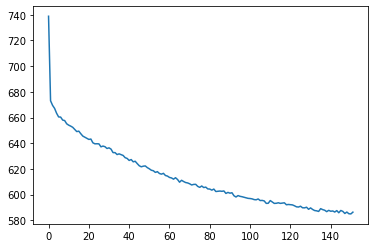

In [14]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(torch.Tensor.cpu(torch.tensor(all_losses)))

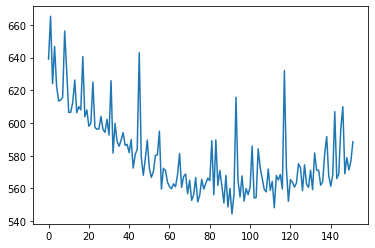

In [15]:
plt.figure()
plt.plot(torch.Tensor.cpu(torch.tensor(validation_losses)))

In [16]:
def view_loss(model, test_set, test_label,criterion):
    total_loss=0
    test_dataset = TensorDataset(test_set, test_label)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        y = torch.reshape(y,(-1,1))
        output = model(x)
        loss = torch.sqrt(criterion(output, y))#RMSE
        total_loss += loss
    return total_loss

In [17]:
test_losses = []
for i in range(100):
    model.load_state_dict(torch.load(f'model_state/model_moreunit_epoch{i}.pth'))
    test_losses.append(view_loss(model,process_features(test),torch.tensor(test_labels).to(torch.float32),criterion)/process_features(test).shape[0]*128)
    print(f"epoch: {i}, test loss: {view_loss(model, process_features(test), torch.tensor(test_labels).to(torch.float32), criterion)/process_features(test).shape[0]*128}")

epoch: 0, test loss: 663.7208862304688
epoch: 1, test loss: 677.3981323242188
epoch: 2, test loss: 667.2691650390625
epoch: 3, test loss: 678.1451416015625
epoch: 4, test loss: 677.7792358398438
epoch: 5, test loss: 674.6776733398438
epoch: 6, test loss: 661.4042358398438
epoch: 7, test loss: 665.6636962890625
epoch: 8, test loss: 659.7330322265625
epoch: 9, test loss: 661.767822265625
epoch: 10, test loss: 649.1384887695312
epoch: 11, test loss: 668.8062133789062
epoch: 12, test loss: 660.4263916015625
epoch: 13, test loss: 651.3436889648438
epoch: 14, test loss: 641.89794921875
epoch: 15, test loss: 665.886474609375
epoch: 16, test loss: 657.0656127929688
epoch: 17, test loss: 642.3844604492188
epoch: 18, test loss: 665.9797973632812
epoch: 19, test loss: 655.0135498046875
epoch: 20, test loss: 643.8012084960938
epoch: 21, test loss: 644.3160400390625
epoch: 22, test loss: 647.5126342773438
epoch: 23, test loss: 639.7796020507812
epoch: 24, test loss: 643.8854370117188
epoch: 25, tes

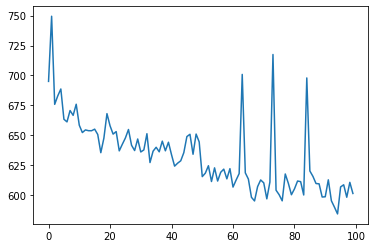

In [18]:
plt.figure()
plt.plot(torch.Tensor.cpu(torch.tensor(test_losses)))

In [12]:
print(model)

MLP(
  (embed_quarter_hour): Embedding(96, 10)
  (embed_day_of_week): Embedding(7, 10)
  (embed_week_of_year): Embedding(52, 10)
  (embed_client_ids): Embedding(20778, 10)
  (embed_taxi_ids): Embedding(440, 10)
  (embed_stand_ids): Embedding(64, 10)
  (layer1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=65, out_features=160, bias=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=160, out_features=100, bias=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=100, out_features=50, bias=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=50, out_features=15, bias=True)
    (2): ReLU()
  )
  (output_layer): Linear(in_features=15, out_features=1, bias=True)
)


In [20]:
model.load_state_dict(torch.load('model_state/model_moreunit_epoch90.pth'))

<All keys matched successfully>

In [21]:
predict_input = torch.tensor(process_features(competition_test)).to(device)
print(predict_input.shape)

torch.Size([320, 11])


/tmp/ipykernel_3235/1078090879.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predict_input = torch.tensor(process_features(competition_test)).to(device)


In [22]:
def predict(model):
    predict_output = model(predict_input)
    return predict_output

In [23]:
out = predict(model)

In [24]:
embed_mlp_predict = pd.read_csv('test_public.csv')
embed_mlp_predict = embed_mlp_predict['TRIP_ID']
predict_tensor = out.to('cpu').detach().numpy().flatten()
embed_mlp_predict= pd.concat([embed_mlp_predict, pd.DataFrame(predict_tensor)], axis=1)
embed_mlp_predict = embed_mlp_predict.rename(columns={0: 'TRAVEL_TIME'})
embed_mlp_predict[0:50]

,TRIP_ID,TRAVEL_TIME
0,T1,688.565613
1,T2,617.014832
2,T3,590.734375
3,T4,693.809814
4,T5,590.229675
5,T6,820.896362
6,T7,812.839172
7,T8,633.154907
8,T9,646.250366
9,T10,902.702332


In [25]:
embed_mlp_predict['TRAVEL_TIME'].mean()

831.89044

In [26]:
embed_mlp_predict.to_csv('Embedding_MLP_moreunit_89.csv', index=False)

In [ ]:
a = process_features(train)
print(a[:,0])
embedding1 = torch.nn.Embedding(96, 10)
embedding2 = torch.nn.Embedding()
print(embedding(a[0,0].to(torch.int32)))